Importing libraries

In [3]:
import pandas as pd
import numpy as np


We want to simplify the dataset by dropping unnecessary rows, I'll start with condensing 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng' columns into a simple 'Location' column, but first I need to see if there is a significant enough distance between the two coordinates.

In [ ]:
# This takes about a minute to load
df = pd.read_csv("Data/US_Accidents_March23.csv")


The below code converts start and endtime to the to_datetime format, and confirms that all the times were parsed successfully.

In [5]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"], format="mixed", errors="coerce")
df["End_Time"] = pd.to_datetime(df["End_Time"], format="mixed", errors="coerce")

# print(df["Start_Time"].isna().sum())
# print(df["End_Time"].isna().sum())

# Merges the columns into one for general duration
df["Duration_Hours"] = (df["End_Time"] - df["Start_Time"]).dt.total_seconds() / 3600
print(df["Duration_Hours"].describe())

count    7.728394e+06
mean     7.407016e+00
std      2.252049e+02
min      2.027778e-02
25%      5.250000e-01
50%      1.247222e+00
75%      2.085833e+00
max      4.688232e+04
Name: Duration_Hours, dtype: float64


Converting the columns with numeric values from strings -> ints
Converting columns with true/false -> boolean

In [6]:
numeric_cols = [
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Distance(mi)"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=numeric_cols)
df[numeric_cols] = df[numeric_cols].astype(int)

binary_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
    "Traffic_Signal", "Turning_Loop"
]

df[binary_cols] = df[binary_cols].astype(bool)

Hypothesis: Accidents occur more frequenly in warmer weather which
is greater than or equal to 32 degrees farhenite then colder weather which
is less than 32 degrees farhenite

Temp_Class
Cold (<32°F)     395944
Warm (≥32°F)    4850867
Name: count, dtype: int64
Chi-square statistic: 3782552.67
P-value: 0.00000


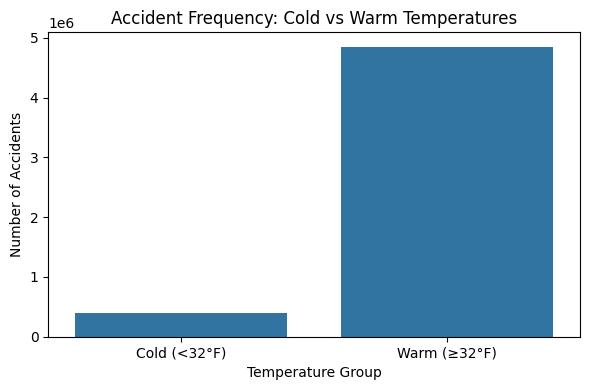

In [10]:

df["Temp_Class"] = df["Temperature(F)"].apply(lambda x: "Cold (<32°F)" if x < 32 else "Warm (≥32°F)")
df_temp = df.dropna(subset=["Temp_Class"])
temp_accident_track = df_temp["Temp_Class"].value_counts().sort_index()
print(temp_accident_track)
from scipy.stats import chisquare

observed = temp_accident_track.values
expected = [observed.sum() / 2] * 2

chi_stat, p_val = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square statistic: {chi_stat:.2f}")
print(f"P-value: {p_val:.5f}")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(x=temp_accident_track.index, y=temp_accident_track.values)
plt.title("Accident Frequency: Cold vs Warm Temperatures")
plt.xlabel("Temperature Group")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()


Well what this tell us that in warmer conditions there are more chances of accidents occuring.
Due to the Chi-sqaure test beings so high shows a correlation and because the p-test is 0 tells 
us that it is not due to chace. 

Conclusion 1:

Conclusion 2:

Conclusion 3: